In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets, models 

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
])


In [7]:
train_dataset = datasets.ImageFolder(root='/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification V2/V2/Training Data', transform=transform)
test_dataset = datasets.ImageFolder(root='/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification V2/V2/Testing Data', transform=transform)
val_dataset = datasets.ImageFolder(root='/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification V2/V2/Validation Data', transform=transform)

In [8]:
# Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
# Define the ResNet18 architecture
class ResNet18(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
my_gpu = torch.cuda.is_available()
print(f'Train on gpu: {my_gpu}')
device = torch.device('cuda' if my_gpu else 'cpu')

Train on gpu: True


In [11]:
class_names=train_dataset.classes
print(class_names)
print(len(class_names))

['Aster', 'Daisy', 'Iris', 'Lavender', 'Lily', 'Marigold', 'Orchid', 'Poppy', 'Rose', 'Sunflower']
10


In [12]:
model = ResNet18(num_classes = len(class_names)).to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
best_checkpoint = torch.load('/kaggle/input/resnetmodelweights/model_checkpoint.pth')
print(best_checkpoint.keys())
model.load_state_dict(best_checkpoint['state_dict'])


dict_keys(['epoch', 'state_dict', 'optimizer', 'train_loss', 'val_loss'])


<All keys matched successfully>

In [14]:
model.eval()

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [16]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            #print(model(x)[0])
            #y_pred, _ = model(x)
            y_pred = model(x)[0]

            outputs.append(y_pred.cpu())
            labels.append(y)
    #print(outputs)
    #outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels
     

In [17]:
outputs, labels = get_representations(model, test_dataloader)


In [18]:
len(outputs)

2355

In [19]:
def plot_representations(data, labels, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')

In [20]:
from sklearn import manifold

In [21]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [22]:
new_array = []
for i in outputs:
  x = i.detach().cpu().numpy()
  new_array.append(x)

new_array = np.asarray(new_array)
new_array.shape
     

(2355, 10)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


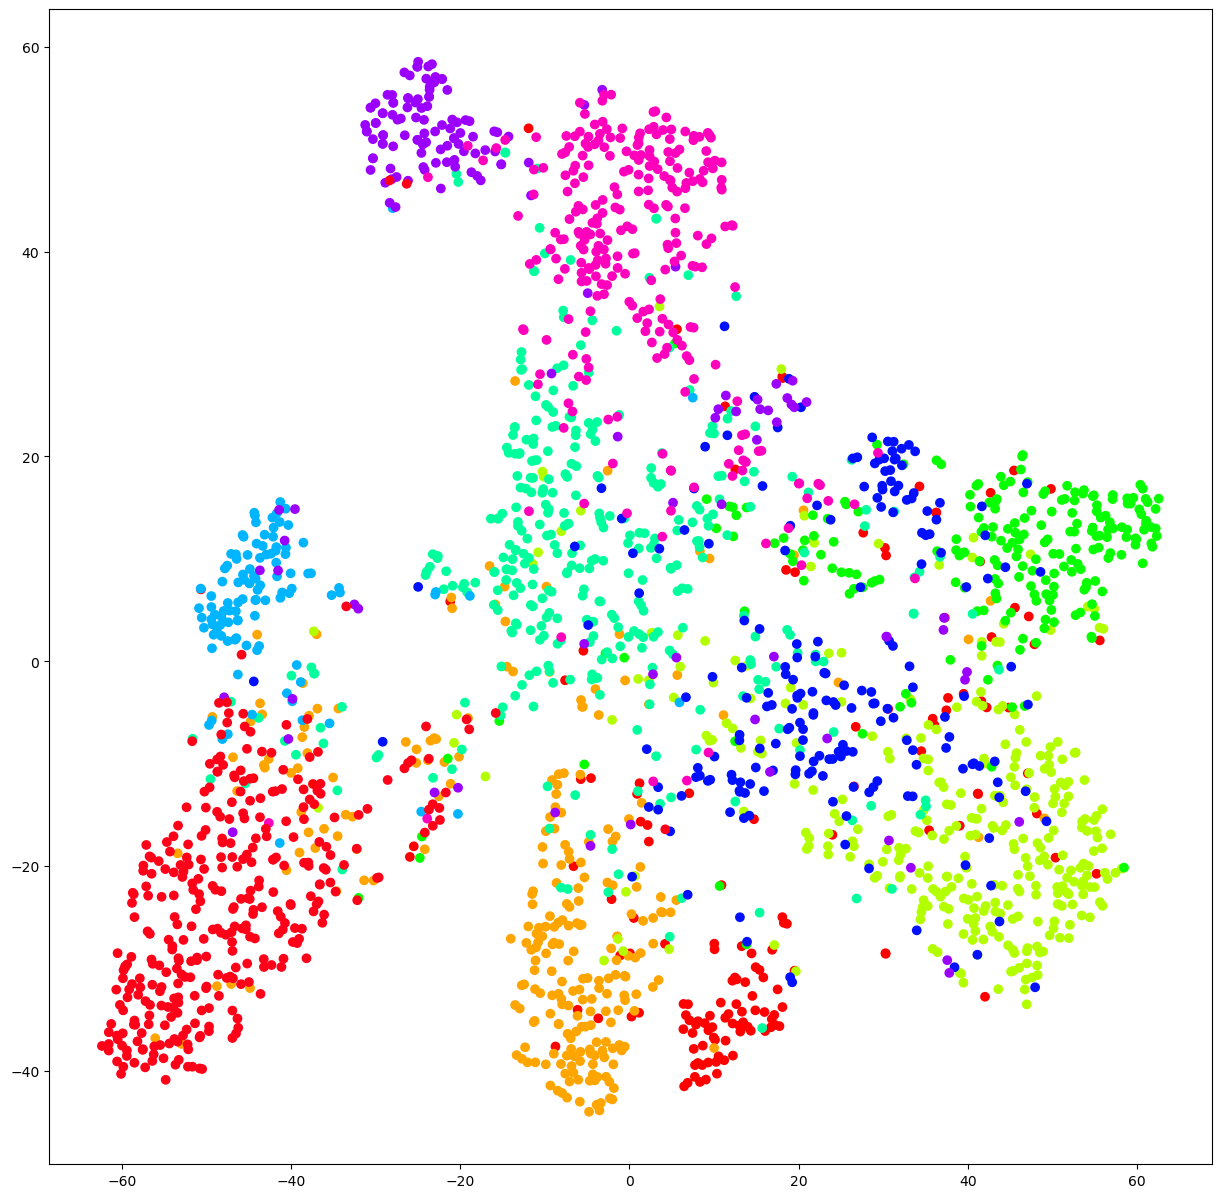

In [23]:
output_tsne_data = get_tsne(new_array)
plot_representations(output_tsne_data, labels)
     